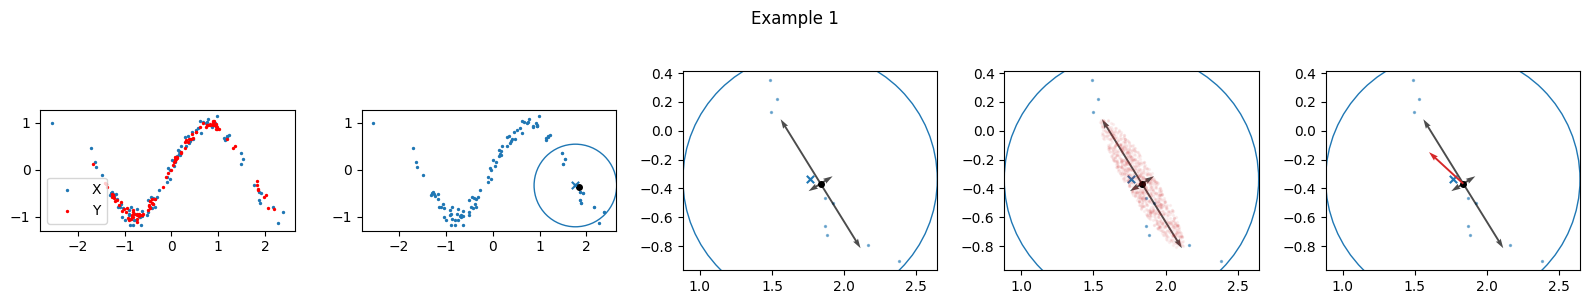

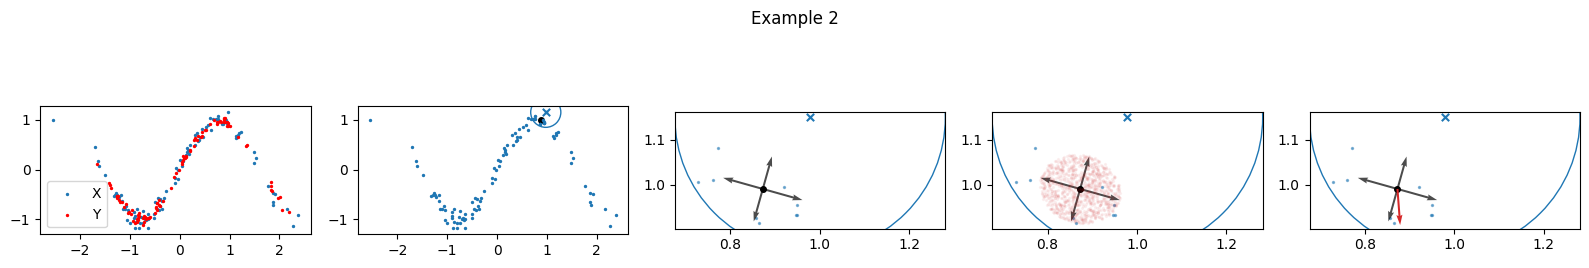

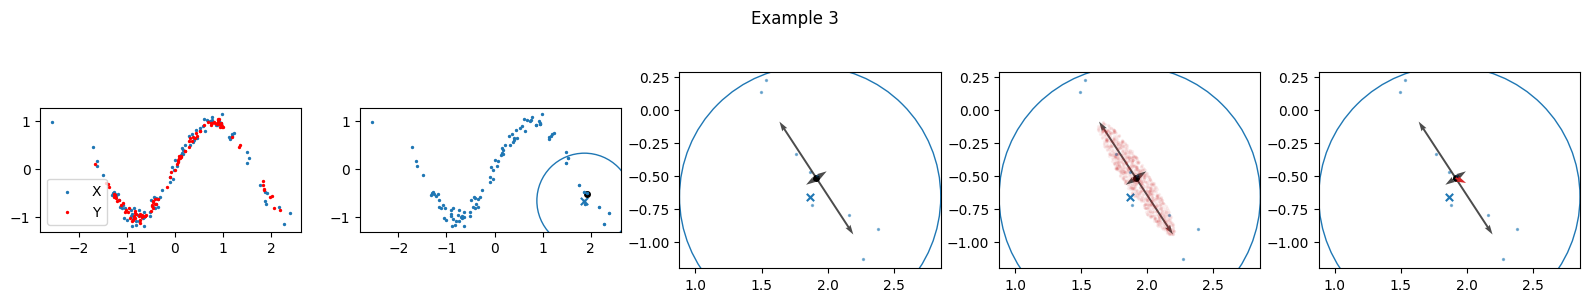

In [134]:
from typing import Any
import numpy as np
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd

def random_in_ellipse(lambdas:np.ndarray|list, size=None, mean_scale=False):
    lambdas = np.asarray(lambdas)
    d, = lambdas.shape
    shape = (1,) if size is None else tuple(np.ravel(size))
    x = np.random.normal(0, 1, size=(*shape, d))
    x = x / np.linalg.norm(x, axis=1)[:,None]
    x = x @ np.diag(lambdas)
    r = np.random.uniform(0, 1, size=shape)**0.5
    if mean_scale:
        r /= (d+1) / (d+2)
    x *= r[:,None]
    return x[0] if size is None else x


N_explore = 10

def algorithm(X: np.ndarray):
    X = np.asarray(X).astype(float)
    N, n = X.shape
    Y = X * np.nan
    # Prepare nearest neighbor search
    tree = cKDTree(X)
    for i_x in range(N):
        xi = X[i_x]
        # Compute neighbors in radius R_noise
        # idx = tree.query_ball_point(x, r=R_explore, p=2)
        _, idx = tree.query(xi, k=N_explore, p=2)
        x = X[idx].mean(axis=0)
        Nx = X[idx] - x
        # Diagonalize covariance matrix
        cov = np.cov(Nx.T)
        try:
            diag, V = np.linalg.eig(cov)
        except np.linalg.LinAlgError:
            print(cov)
            print(Nx.shape)
            raise
        lambdas = np.sqrt(diag)
        # Sample a random direction
        y = random_in_ellipse(lambdas)
        y = V @ y + x
        Y[i_x] = y
    return Y


def algorithm_plot(X: np.ndarray, i_x=None, axes=None):
    X = np.asarray(X).astype(float)
    tree = cKDTree(X)
    N, n = X.shape
    assert n==2
    if i_x is None:
        i_x = np.random.randint(N)
    xi = X[i_x]
    # idx = tree.query_ball_point(xi, r=R_explore, p=2)
    _, idx = tree.query(xi, k=N_explore, p=2)
    x = X[idx].mean(axis=0)
    Nx = X[idx] - x
    # Diagonalize covariance matrix
    cov = np.cov(Nx.T)
    diag, V = np.linalg.eig(cov)
    lambdas = np.sqrt(diag)
    plot_radius = np.max(np.linalg.norm(Nx + x - xi, axis=1))* 1.05 
    plot_xlims = xi[0] + plot_radius* np.array([-1, 1])
    AxesType = plt.Axes # type:ignore
    def subset_plot(ax:"AxesType", show=[]):
        features = {k:True for k in show}
        ax.set_aspect('equal')
        if features.get('xi'):
            ax.scatter(xi[None,0], xi[None,1], marker='x', s=28, color='tab:blue')
        if features.get('x'):
            ax.scatter(x[None,0], x[None,1], marker='o', s=16, color='black')
        if features.get('X'):
            ax.scatter(X[:,0], X[:,1], label='X', s=2, color='tab:blue')
        if features.get('circle'):
            radius = np.max(np.linalg.norm(Nx + x - xi, axis=1))* 1.05
            circle = plt.Circle(xi, radius, fill=False, color='tab:blue') # type: ignore
            ax.add_artist(circle)
        if features.get('Nx'):
            ax.scatter(x[0]+Nx[:,0], x[1]+Nx[:,1], label='X', s=2, marker='o', color='tab:blue', alpha=0.5)
        # if features.get('Nxi'):
        #     ax.scatter(xi[0]+Nxi[:,0], xi[1]+Nxi[:,1], label='X', s=5, marker='o', color='tab:blue')
        if features.get('V'):
            for i_v in range(n):
                u = V[:, i_v] * lambdas[i_v]
                ax.quiver(*x, *u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
                ax.quiver(*x, *-u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
        if features.get('Y'):
            ax.scatter(Y[:,0], Y[:,1], s=2, c='tab:red', alpha=0.05) # For the plot limits 
            # xx = np.zeros_like(Y)
            # xx[:] = x[None,:]
            # ax.quiver(*xx.T, *(Y-x[None,:]).T, scale=1, scale_units='xy', color='tab:red', alpha=0.2)
        if features.get('Y_contour'):
            kw:Any = dict(fill=False, alpha=0.9, levels=5, linewidths=0.5)
            sns.kdeplot(data=pd.DataFrame(Y), x=0, y=1, ax=ax, color='tab:red', **kw)
        if features.get('y'):
            ax.quiver(*x, *(y-x),  scale=1, scale_units='xy', color='tab:red', alpha=1)
        if features.get('y_mean'):
            ax.quiver(*x, *(y_mean-x),  scale=1, scale_units='xy', color='tab:purple', alpha=1)
        return
    
    y = random_in_ellipse(lambdas, mean_scale=True)
    y = V @ y + x

    # Do the sampling many times to show a contour plot
    N_samples = 1000
    Y = random_in_ellipse(lambdas, size=N_samples)
    Y =  (V @ Y.T).T + x[None, :]
    y_mean = np.mean(Y, axis=0)

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(5, 5))
        axes = axes.flatten()
    subset_plot(axes[0], show='X xi x circle Nx'.split())
    subset_plot(axes[1], show='xi x circle Nx V'.split())
    # axes[1].set_xlim(axes[0].get_xlim())
    axes[1].set_xlim(*plot_xlims)
    subset_plot(axes[2], show='xi x circle Nx V Y'.split())
    axes[2].set_xlim(*plot_xlims)
    # subset_plot(axes[3], show='xi x circle Nx Y_contour'.split())
    subset_plot(axes[3], show='xi x circle Nx V y'.split())
    axes[3].set_xlim(*plot_xlims)
    return

# Generate test data
import matplotlib.pyplot as plt

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
X[:,1] =  X[:,1] * 0.1 + np.sin(2*X[:,0])
Y = algorithm(X)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(X, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()


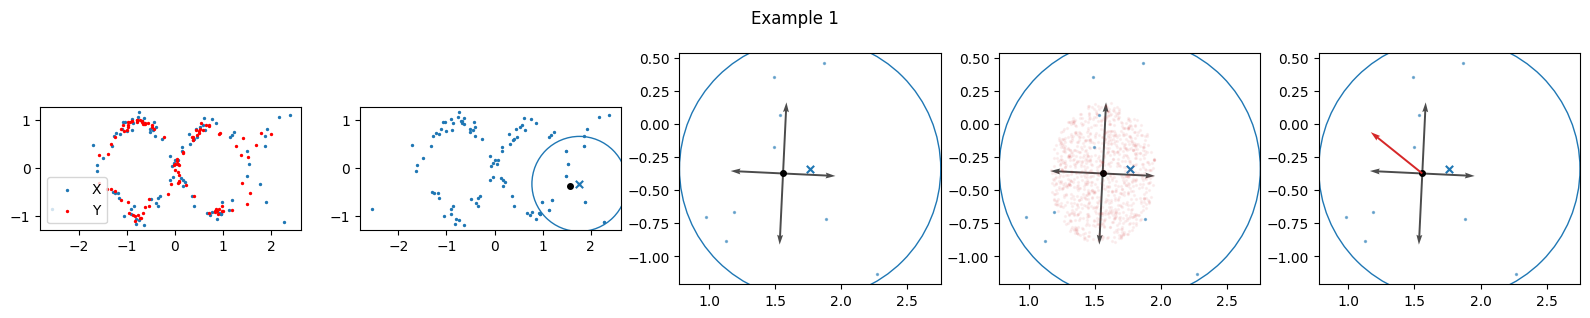

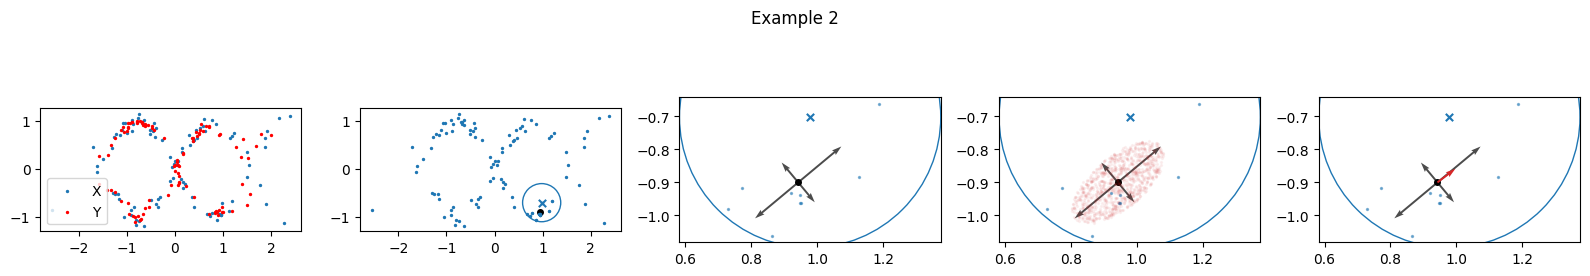

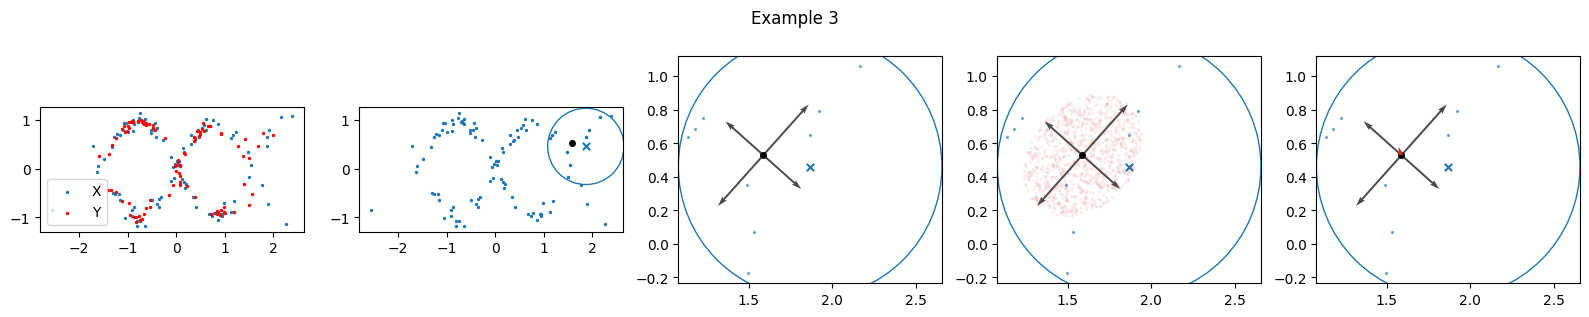

In [135]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
mask = np.random.rand(len(X)) > 0.5
X[mask,1] =  X[mask,1] * 0.1 + np.sin(2*X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(2*X[mask,0])
Y = algorithm(X)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(X, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

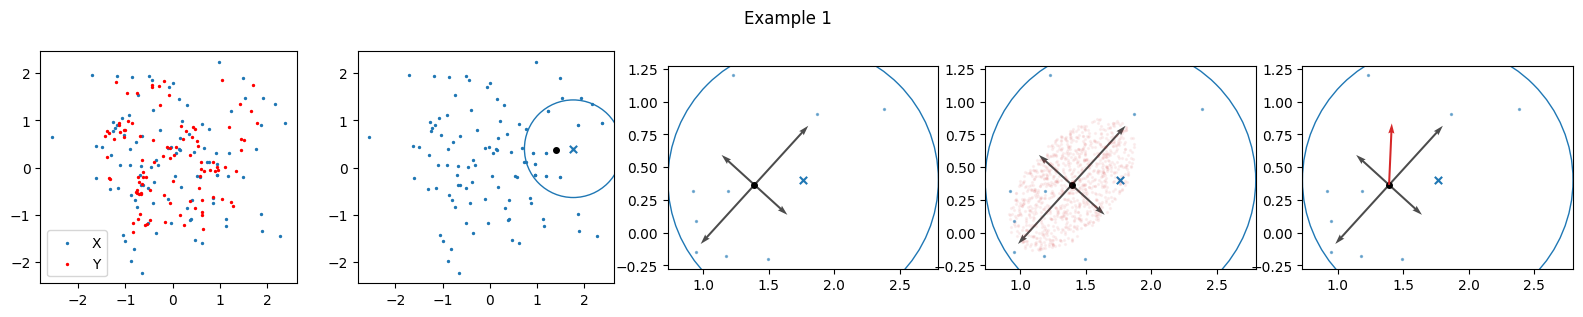

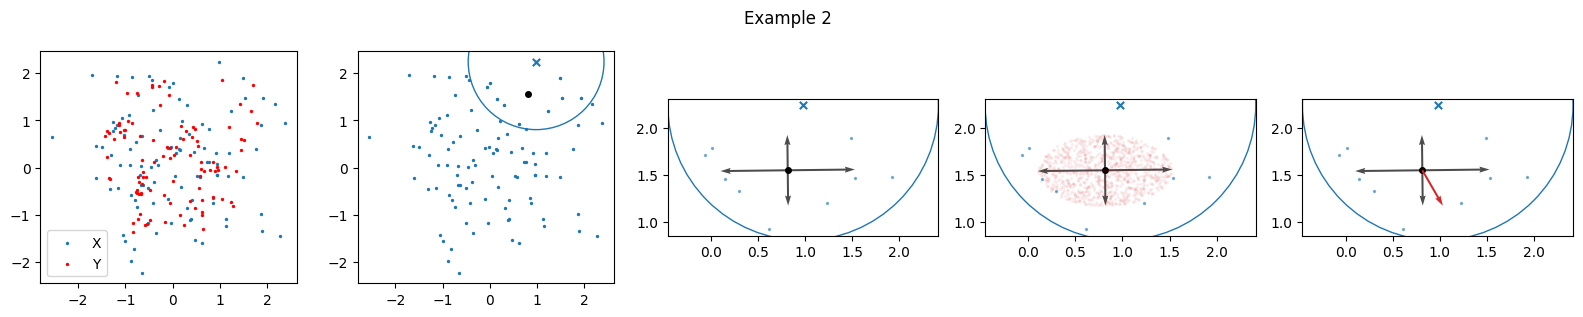

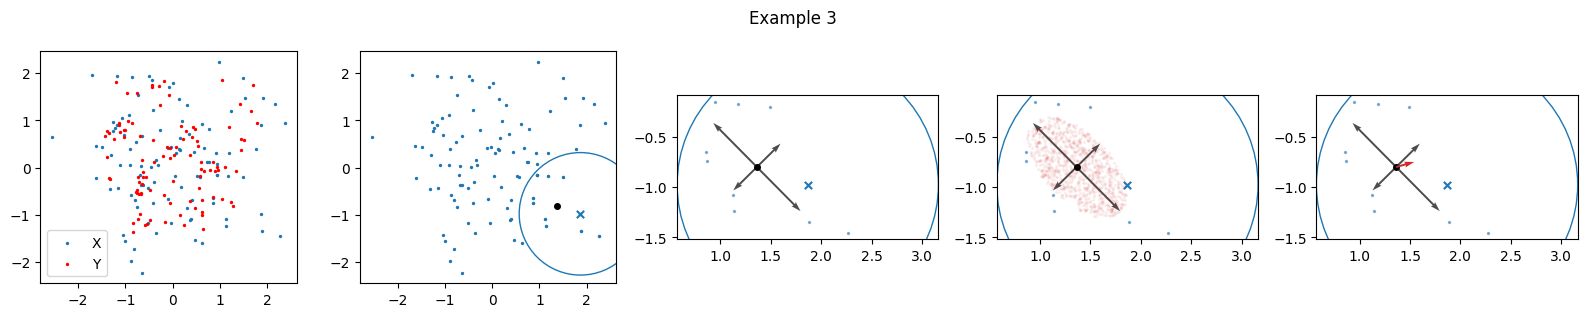

In [136]:

np.random.seed(0)
X = np.random.normal(0, 1, (100,2))
Y = algorithm(X)

for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].legend()
    algorithm_plot(X, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()